In [1]:
# %matplotlib widget
import scipp as sc
import scippneutron as scn
import plopp as pp
from pathlib import Path
from ess import reflectometry
from datetime import datetime
import platform
import numpy as np

import ess
from scitacean import Dataset, PID
from scitacean.testing.client import FakeClient
from scitacean.testing.transfer import FakeFileTransfer

from orsopy import fileio
from scitacean.transfer.ssh import SSHFileTransfer

pp.patch_scipp()

In [2]:
logger = ess.logging.configure_workflow('offspec_reduction',
                                        filename='offspec.log')

# Set up the SciCat database locally

First, we will set up a fake SciCat database and add our raw data to this. 
This is achieved with the `scitacean` package, which is also compatible with the real ESS SciCat instance. 

In [3]:
client = FakeClient(file_transfer=FakeFileTransfer(source_folder='/'))

The direct beam NeXus file is added to a dataset that is "uploaded" to the fake SciCat instance. 

In [4]:
direct_beam_dataset = Dataset(
    name="OFFSPEC Direct Beam Data",
    description="Raw OFFSPEC data from the direct beam.",
    type="raw",
    
    owner_group="ess",
    access_groups=["offspec"],
    
    owner="Joshanial F. K. Cooper",
    principal_investigator="Joshanial F. K. Cooper",
    contact_email="jos.cooper@stfc.ac.uk",
    
    data_format="ISIS NeXus file"
)
file = './direct_beam.nxs'
direct_beam_dataset.add_local_files(file, base_path='.')
direct_beam_dataset.creation_location = "ISIS Neutron and Muon Source"
direct_beam_dataset.instrument_id = "OFFSPEC"
direct_beam_uploaded = client.upload_new_dataset_now(direct_beam_dataset)

Similar for the sample dataset, which is data from a system of quartz and copper at the air-silicon interface. 

In [5]:
sample_dataset = Dataset(
    name="OFFSPEC Sample Data",
    description="Raw OFFSPEC data from quartz and copper at the air-silicon interface.",
    type="raw",
    
    owner_group="ess",
    access_groups=["offspec"],
    
    owner="Joshanial F. K. Cooper",
    principal_investigator="Joshanial F. K. Cooper",
    contact_email="jos.cooper@stfc.ac.uk",
    
    data_format="ISIS NeXus file"
)
file = './sample.nxs'
sample_dataset.add_local_files(file, base_path='.')
sample_dataset.creation_location = "ISIS Neutron and Muon Source"
sample_dataset.instrument_id = "OFFSPEC"
sample_dataset.meta['direct_beam_pid'] = str(direct_beam_uploaded.pid)
sample_dataset.meta['sample_name'] = "QCS sample"
sample_dataset.meta['sample_category'] = "gas/solid"
sample_dataset.meta['sample_composition'] = "Air | Si(790 A) | Cu(300 A) | SiO2"
sample_pid = PID(prefix="sample.prefix", pid="1234-5678-abce")
sample_uploaded = client.upload_new_dataset_now(sample_dataset)

## Loading the data

The data can then be obtained from the SciCat instance and loaded below. 
The direct beam measurement is obtained by positioning the detector directly in the beam of incident neutrons and moving the sample out of the way and gives an estimate for the ISIS pulse structure as a function of time-of-flight. 

In [6]:
sample_remote = client.get_dataset(sample_uploaded.pid)
sample_local = client.download_files(sample_remote, target=".")
sample = scn.load(sample_local.files[0].local_path, mantid_args={"LoadMonitors": True})
sample.coords['theta'] = sample.attrs.pop('Theta').value[-1].data

/Users/andrewmccluskey/mambaforge/envs/ess-mantid/lib/python3.8/site-packages/scitacean/file.py:238: UserWarning: Cannot check if local file sample.nxs is up to date because the checksum algorithm is not set. Assuming the file needs to be updated.
  warnings.warn(
File 'sample.nxs' has a checksum but no algorithm has been set. Skipping check. Checksum is f18a8122706201df8150e7556ae6eb59
Workspace run log 'good_frames' has unrecognised units: 'frames'
Workspace run log 'period_change_log' has unrecognised units: 'period_number'
Workspace run log 'raw_frames' has unrecognised units: 'frames'
Workspace run log 'veto_log' has unrecognised units: 'is_vetoing'
Workspace run log 'events_log' has unrecognised units: 'events'
Workspace run log 'frame_log' has unrecognised units: 'frame_number'
Workspace run log 'good_frame_log' has unrecognised units: 'is_good'
Workspace run log 'period_log' has unrecognised units: 'period_number'
Workspace run log 'raw_events_log' has unrecognised units: 'even

In [7]:
direct_beam_remote = client.get_dataset(direct_beam_uploaded.pid)
direct_beam_local = client.download_files(direct_beam_remote, target=".")
direct_beam = scn.load(direct_beam_local.files[0].local_path, mantid_args={"LoadMonitors": True})

Cannot check if local file direct_beam.nxs is up to date because the checksum algorithm is not set. Assuming the file needs to be updated.
File 'direct_beam.nxs' has a checksum but no algorithm has been set. Skipping check. Checksum is e929d3419b13c3ffa4a5545ec54f9044
Workspace run log 'good_frames' has unrecognised units: 'frames'
Workspace run log 'period_change_log' has unrecognised units: 'period_number'
Workspace run log 'raw_frames' has unrecognised units: 'frames'
Workspace run log 'veto_log' has unrecognised units: 'is_vetoing'
Workspace run log 'events_log' has unrecognised units: 'events'
Workspace run log 'frame_log' has unrecognised units: 'frame_number'
Workspace run log 'good_frame_log' has unrecognised units: 'is_good'
Workspace run log 'period_log' has unrecognised units: 'period_number'
Workspace run log 'raw_events_log' has unrecognised units: 'events'


## Populating the ORSO header

We will write the reduced data file following the [ORSO `.ort` stardard](https://www.reflectometry.org/file_format/specification), to enable a metadata rich header. 
We will create an empty header and then populate this. 

### The data source information

Many aspects of the ORSO header can be populate directly from the raw data file (in particular within the `data_source` section). 

In [8]:
header = fileio.orso.Orso.empty()

header.data_source.owner = fileio.base.Person(name=sample_local.owner, 
                                              affiliation='ISIS Neutron and Muon Source', 
                                              contact=sample_local.contact_email)
header.data_source.experiment = fileio.data_source.Experiment(title=sample_local.name, 
                                                              instrument=sample_local.instrument_id, 
                                                              start_date=sample_local.created_at, 
                                                              probe='neutron', 
                                                              facility=sample_local.creation_location)
header.data_source.sample = fileio.data_source.Sample(name=sample_local.meta['sample_name'], 
                                                      category=sample_local.meta['sample_category'], 
                                                      composition=sample_local.meta['sample_composition'])
header.data_source.measurement = fileio.data_source.Measurement(instrument_settings=fileio.data_source.InstrumentSettings(incident_angle=fileio.base.Value(sample.coords['theta'].value, sample.coords['theta'].unit), 
                                                                                                                          wavelength=None,
                                                                                                                          polarization='unpolarized'),
                                                                data_files=[str(sample_local.pid), str(direct_beam_local.pid)],
                                                                scheme='energy-dispersive')

### The reduction details

The `reduction` section can start to be populated also. 
Entries such as `corrections` will be filled up through the reduction process. 

In [9]:
header.reduction.software = fileio.reduction.Software(name='scipp', version=sc.__version__, platform=platform.platform())
header.reduction.timestamp = datetime.now()
header.reduction.creator = fileio.base.Person(name='Andrew R. McCluskey', 
                                              affiliation='European Spallation Source', 
                                              contact='andrew.mccluskey@ess.eu')
header.reduction.corrections = []
header.reduction.computer = platform.node()
header.reduction.script = '/Users/andrewmccluskey/work/reduction/ess/docs/instruments/external/offspec/offspec_mantid.ipynb'

To ensure that the header object is carried through the process, we assign it to the sample `scipp.DataArray`. 
The direct beam header object will be overwritten at the normalisation step so we will keep this empty. 

In [10]:
sample.attrs['orso'] = sc.scalar(header)
direct_beam.attrs['orso'] = sc.scalar(fileio.orso.Orso.empty())

### Correcting the position of detector pixels

The pixel positions in sample file must be modified to account for the transformation on the detector by rotating it around the sample. 
We can achieve this by understanding that the sample has been rotated by some amount (as discussed above) and that sample measurement has the specular peak at the same pixel as the direct beam measurement has the direct beam. 
Therefore, we move the sample detector along the arc of the sample rotation by $2\omega$ (in the OFFSPEC files, $\omega$ is called `'Theta'`, which we stored as `'theta'` earlier). 

In [11]:
from scipp.spatial import rotations_from_rotvecs

def pixel_position_correction(data: sc.DataArray):
    rotation = rotations_from_rotvecs(rotation_vectors=sc.vector(value=[-2.0 * data.coords['theta'].value, 0, 0], unit=sc.units.deg))
    return rotation * (data.coords['position'] - data.coords['sample_position'])

In [12]:
logger.info("Correcting pixel positions in 'sample.nxs'")
sample.coords['position'] = pixel_position_correction(sample)
sample.attrs['orso'].value.data_source.measurement.comment = 'Pixel positions corrected'

We can visualize the data with a plot. 
In this plot of `sample`, we can see the specular intensity at around spectrum numbers 400-410. 
There is a more intense region, closer to spectrum number 300, which comes from the direct beam of neutrons traveling straight through our sample. 

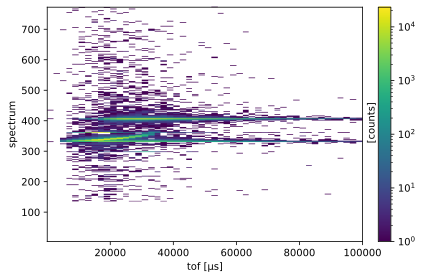

In [13]:
sample.hist(tof=50).plot(norm='log')

A region of interest is then defined for the detector. 
This is defined as twenty-five pixels around the specular peak or the direct beam. 
The `scipp.DataArray` is concatentated along the `'spectrum'` coordinate at this stage, essentially collaposing all of the events onto a single pixel.

In [14]:
sample_roi = sample['spectrum', 389:415].bins.concat('spectrum')
direct_beam_roi = direct_beam['spectrum', 389:415].bins.concat('spectrum')

sample_roi.attrs['orso'].value.reduction.corrections += ['region of interest defined as spectrum 389:415']

The position of these events is then defined as the centre of the region of interest. 

In [15]:
sample_roi.coords['position'] = sample.coords['position'][401]
direct_beam_roi.coords['position'] = direct_beam.coords['position'][401]

## Coordinate transform graph

To compute the wavelength $\lambda$, the scattering angle $\theta$, and the $Q$ vector for our data we can use a coordinate transform graph. 
The reflectometry graph is discussed in detail in the [Amor reduction notebook](https://scipp.github.io/ess/instruments/amor/amor_reduction.html) and the one used here is nearly identical.
The only difference is the Amor instrument uses choppers to define the pulse of neutrons, which is not the case here. 
The OFFSPEC graph is the standard reflectometry graph, shown below. 

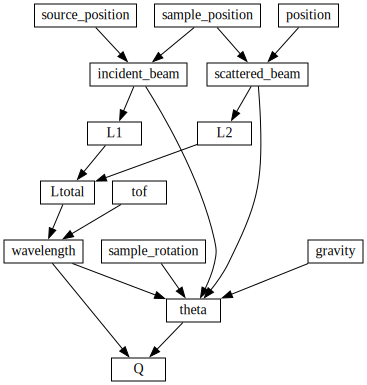

In [16]:
graph = {**reflectometry.conversions.specular_reflection()}
sc.show_graph(graph, simplified=True)

## Computing the wavelength

The neutron wavelengths can be computed with `transform_coords` and the graph shown above. 
We will only use neutrons in the wavelength range of 1.5 Å to 12.0 Å. 

In [17]:
wavelength_edges = sc.linspace(dim='wavelength', start=2, stop=15, num=2, unit='angstrom')
sample_wav = reflectometry.conversions.tof_to_wavelength(sample_roi, wavelength_edges,graph=graph)

Since the direct beam measurement is **not** a reflectometry measurement, we use the `no_scatter_graph` to convert this to wavelength.

In [18]:
no_scatter_graph = {**scn.conversion.graph.beamline.beamline(scatter=False),
                    **scn.conversion.graph.tof.elastic_wavelength(start='tof')}
sc.show_graph(no_scatter_graph, simplified=True)

direct_beam_wav = direct_beam_roi.transform_coords('wavelength', graph=no_scatter_graph)
direct_beam_wav = direct_beam_wav.bin(wavelength=wavelength_edges)

## Normalization by monitor

It is necessary to normalize the sample and direct beam measurements by the summed monitor counts, which accounts for different lengths of measurement and long-timescale natural variation in the pulse. 
This will ensure that the final data has the correct scaling when the reflectivity data is normalized.
First, we convert the data to wavelength, using the `no_scatter_graph` used previously for the direct beam.

The most reliable monitor for the OFFSPEC instrument is `'monitor2'` in the file, therefore this is used. 

In [19]:
sample_mon_wav = sample_roi.attrs['monitor2'].value.transform_coords('wavelength', graph=no_scatter_graph)
direct_beam_mon_wav = direct_beam_roi.attrs['monitor2'].value.transform_coords('wavelength', graph=no_scatter_graph)

A background subtraction is then performed on the monitor data, where the background as taken as any counts at wavelengths greater than 15 Å. 

In [20]:
sample_mon_wav -= sc.values(sample_mon_wav['wavelength', 15 * sc.units.angstrom].mean())
direct_beam_mon_wav -= sc.values(direct_beam_mon_wav['wavelength', 15 * sc.units.angstrom].mean())
sample_wav.attrs['orso'].value.reduction.corrections += ['monitor background subtraction, background above 15 Å']

The monitors are then summed along the `'wavelength'` and this value is used to normalise the data. 

In [21]:
sample_mon_wav_sum = sample_mon_wav['wavelength', 2 * sc.units.angstrom:15 * sc.units.angstrom].sum()
direct_beam_mon_wav_sum = direct_beam_mon_wav['wavelength', 2 * sc.units.angstrom:15 * sc.units.angstrom].sum()
sample_norm = sample_wav / sc.values(sample_mon_wav_sum)
direct_beam_norm = direct_beam_wav / sc.values(direct_beam_mon_wav_sum)
sample_wav.attrs['orso'].value.reduction.corrections += ['normalisation by summed monitor']

## Normalisation of sample by direct beam

The sample and direct beam measurements (which have been normalised by monitor counts) are then histogrammed in wavelength to 100 geometrically spaced points. 
The histogrammed direct beam is then used to normalised the sample. 

Improtantly, some relevant metadata (including the ORSO header object) is carried over. 

In [22]:
sample_norm_hist = sample_norm.hist(wavelength=sc.geomspace(dim='wavelength', start=2, stop=14, num=100, unit=sc.units.angstrom))
direct_beam_norm_hist = direct_beam_norm.hist(wavelength=sc.geomspace(dim='wavelength', start=2, stop=14, num=100, unit=sc.units.angstrom))
sample_norm_hist.coords['sample_position'] = sample_norm.attrs.pop('sample_position')

norm_wav = sample_norm_hist / direct_beam_norm_hist
norm_wav.attrs['position'] = sample_wav.attrs['position']
norm_wav.attrs['orso'] = sample_wav.attrs['orso']
norm_wav.coords['theta'] = sample_wav.coords['theta']

norm_wav.attrs['orso'].value.reduction.corrections += ['normalisation by direct beam']

## Conversion to $Q$

This normalised data can then be used to compute the reflectivity as a function of the scattering vector $Q$. 

In [23]:
norm_q = reflectometry.conversions.theta_to_q(norm_wav, graph=graph)

Which we can visualise.

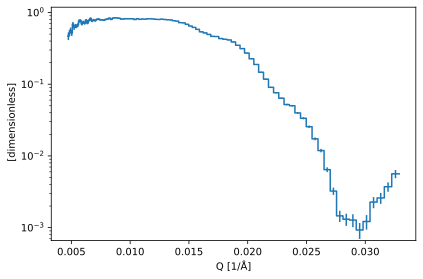

In [24]:
norm_q.plot(norm='log')

## Comparison with Mantid

The same data was reduced with Mantid for comparison. 

We will add this to our SciCat instance as a derived dataset of the sample. 

In [25]:
reduced_mantid = sample_local.derive()
reduced_mantid.add_local_files('./mantid.dat', 
                        base_path='.')
reduced_mantid.contact_email = 'jos.cooper@stfc.ac.uk'
reduced_mantid.name = 'Reduced (by mantid) reflectometry data from QCS sample'
reduced_mantid.used_software = ['mantid']
reduced_mantid.investigator = 'Joshanial F. K. Cooper'
reduced_mantid.owner_group = sample_local.owner_group
reduced_mantid.input_datasets.append(direct_beam_local.pid)

reduced_mantid_up = client.upload_new_dataset_now(reduced_mantid)

We can then get this dataset and load it (with `numpy` as it is not an ORSO file) before transforming it to a `scipp.DataArray` for each plotting.

In [26]:
reduced_mantid_remote = client.get_dataset(reduced_mantid_up.pid)
reduced_mantid_local = client.download_files(reduced_mantid_remote, target=".")
mantid_q, mantid_r, mantid_dr = np.loadtxt(reduced_mantid_local.files[0].local_path, delimiter=',', unpack=True)

mantid = sc.DataArray(coords={'Q': sc.array(dims=['Q'], values=mantid_q, unit='1/Å')}, data=sc.array(dims=['Q'], values=mantid_r, variances=np.square(mantid_dr)))

Cannot check if local file mantid.dat is up to date because the checksum algorithm is not set. Assuming the file needs to be updated.
File 'mantid.dat' has a checksum but no algorithm has been set. Skipping check. Checksum is 1f372f51d2cefb8dee302cf0093b684f


We can see there is excellent agreement between the two softwares. 
Small differences present are a result of the different $Q$-bins that are used. 

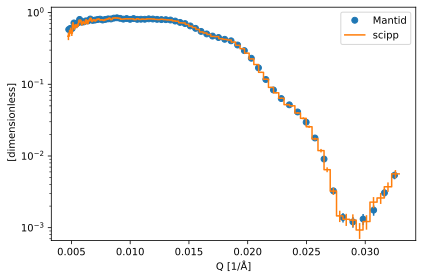

In [27]:
sc.plot({'Mantid': mantid, 'scipp': (norm_q)}, norm='log')

## Saving the scipp-reduced data as .ort

We constructed the ORSO header through the reduction process. 
We can now make use of this when we save our .ort file. 

First, we will assume a 3 % of $Q$ resolution function to be included in our file.

In [28]:
norm_q.coords['sigma_Q'] = sc.midpoints(norm_q.coords['Q']) * 0.03

Then, due a [bug in orsopy](https://github.com/reflectivity/orsopy/pull/101), we need to overwrite the incident angle and wavelength that have been out-populated by the reduction. 

In [29]:
incident_angle = norm_q.attrs['orso'].value.data_source.measurement.instrument_settings.incident_angle
wavelength = norm_q.attrs['orso'].value.data_source.measurement.instrument_settings.wavelength

norm_q.attrs['orso'].value.data_source.measurement.instrument_settings.wavelength = fileio.base.ValueRange(min=float(wavelength.min), max=float(wavelength.max), unit=wavelength.unit)
norm_q.attrs['orso'].value.data_source.measurement.instrument_settings.incident_angle = fileio.base.Value(magnitude=float(incident_angle.magnitude), unit=incident_angle.unit)

And it is necessary to add the column for our uncertainties, which details the **meaning** of the uncertainty values we have given. 

In [30]:
norm_q.attrs['orso'].value.columns.append(fileio.base.ErrorColumn(error_of='R', error_type='uncertainty', value_is='sigma'))
norm_q.attrs['orso'].value.columns.append(fileio.base.ErrorColumn(error_of='Q', error_type='resolution', value_is='sigma'))

Finally, we can save the file.

In [31]:
reflectometry.io.save_ort(norm_q, 'offspec.ort')

In [32]:
!head offspec.ort

# # ORSO reflectivity data file | 1.0 standard | YAML encoding | https://www.reflectometry.org/
# data_source:
#   owner:
#     name: Joshanial F. K. Cooper
#     affiliation: ISIS Neutron and Muon Source
#     contact: jos.cooper@stfc.ac.uk
#   experiment:
#     title: OFFSPEC Sample Data
#     instrument: OFFSPEC
#     start_date: null


## Adding the reduced data to SciCat

The final step is to upload out new reduced data to SciCat as a derived dataset.

In [33]:
reduced = sample_local.derive()

reduced.add_local_files('./offspec.ort', base_path='.')
reduced.contact_email = 'andrew.mccluskey@ess.eu'
reduced.input_datasets.append(direct_beam_local.pid)
reduced.name = 'Reduced reflectometry data from QCS sample'
reduced.used_software = ['scipp-23.01.1']
reduced.investigator = 'Andrew R. McCluskey'
reduced.owner_group = sample_local.owner_group

reduced_up = client.upload_new_dataset_now(reduced)